** What I want to do: ** Establish connection to bitcoin and altcoin exchanges and download price charts. Bonus points for downloading my order history as well

## 01 Admin and imports

In [1]:
# the usual suspects...
import os, sys
from datetime import datetime
import numpy as np
import pandas as pd
import itertools

In [2]:
sys.version

'3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:14:59) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [3]:
# this is for my bitcoin prices
import quandl

In [4]:
# visualisation libraries: I'll go ahead and use plotly (offline) for graphing because its d3 
# and so I can track prices over time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sct
import seaborn as sns
sns.set()
sns.set(style="ticks")
sns.set_color_codes("muted")

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
pd.set_option('display.float_format', lambda x:'%.10f' %x)
import glob

In [5]:
# we'll need this for plotting in nice colours. Trust me on this.
COLOR_PALETTE = [    
               "#348ABD",
               "#A60628",
               "#7A68A6",
               "#467821",
               "#CF4457",
               "#188487",
               "#E24A33"
              ]

## 02 Get bitcoin prices

Quandl gives you a free [unlimited data API for bitcoin](https://blog.quandl.com/api-for-bitcoin-data). tl;dr: Bitcoin codes for different exchanges need to follow the format - 
BCHARTS/{MARKET}{CURRENCY}

So, if I want to get AUD exchange rate on BTCMarket exchange (as mentioned on the website): http://www.quandl.com/api/v3/datasets/BCHARTS/BTCMARKETSAUD 


In [6]:
# which currency are we playing in?
fiat_currency_of_choice='AUD'

In [7]:
# do we need to get latest data?
bool_i_prefer_to_work_offline=True
# if either BTCMARKETSAUD*.csv doesnt exist or the date in file is lesser than today's date then you need to update
# the -1 in the comparison step should take care of multiple files since I assume glob picks up files alphanumerically
if len(glob.glob('BTCMARKETS'+fiat_currency_of_choice+'*'))>0:
    if int(datetime.today().strftime('%Y%m%d')) >= int(glob.glob('BTCMARKETS'+fiat_currency_of_choice+'*')[-1].split('.')[0].split('_')[1]):
        bool_i_prefer_to_work_offline = False
    date_of_latest_available_data=glob.glob('BTCMARKETS'+fiat_currency_of_choice+'*')[-1].split('.')[0].split('_')[1]

In [8]:
bool_i_prefer_to_work_offline

False

In [9]:
# bool_i_prefer_to_work_offline=True 

In [10]:
if bool_i_prefer_to_work_offline==False:
    %time df_btc = quandl.get('BCHARTS/BTCMARKETS'+fiat_currency_of_choice, returns="pandas")
    df_btc.to_csv('BTCMARKETS'+fiat_currency_of_choice+'_'+datetime.today().strftime('%Y%m%d')+'.csv')
else:
    %time df_btc = pd.read_csv('BTCMARKETS'+fiat_currency_of_choice+'_'+date_of_latest_available_data+'.csv', parse_dates=['Date'])
    df_btc.set_index('Date',inplace=True)
df_btc.shape

CPU times: user 277 ms, sys: 12.2 ms, total: 289 ms
Wall time: 1.95 s


(1576, 7)

Haha that was quick! 

## 03 Explore pricing data

In [11]:
df_btc.describe()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
count,1576.0000000000,1576.0000000000,1576.0000000000,1576.0000000000,1576.0000000000,1576.0000000000,1576.0000000000
mean,1559.8552163706,1616.7718534264,1493.3125402284,1571.7065645305,194.3427500887,707528.8154671633,1555.8182267120
std,3046.8032644639,3190.3308302771,2871.5489267806,3082.6711631746,218.0392545173,3388085.5338515374,3034.8286711865
min,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,406.4575000000,421.3275000000,392.1875000000,406.1775000000,41.6602271950,21046.1377123250,404.8208590288
50%,627.2900000000,641.5150000000,612.5300000000,627.9650000000,151.7891112300,83734.3935930000,626.1377157465
75%,1039.7100000000,1062.5900000000,1003.3850000000,1032.4925000000,275.4959559900,227977.0070537500,1030.7453789200
max,26802.0100000000,26999.0000000000,25540.0100000000,26802.6400000000,3065.0017915500,69615178.3135000020,26269.6086783000


In [12]:
df_btc.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2013-08-30,125.0000000000,125.0000000000,125.0000000000,125.0000000000,0.0100000000,1.2500000000,125.0000000000
2013-08-31,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-09-01,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-09-02,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-09-03,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


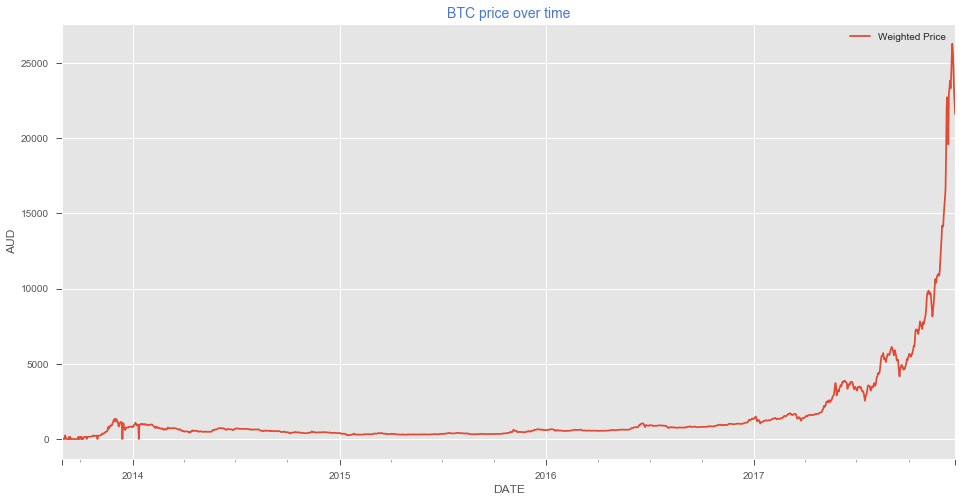

In [13]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
df_btc['Weighted Price'].plot()
plt.title('BTC price over time', color='B',size=14);plt.legend(loc='best');plt.ylabel('AUD');plt.xlabel('DATE')
plt.show()

Notice how the prices fall to 0 around 2014! WTF? I dont remember prices dropping to 0 at any stage. Let me check.

In [14]:
df_btc[(df_btc.index>'2013-10-01') & 
       (df_btc.index<'2014-02-01') & 
       (df_btc['Weighted Price']<100)]

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2013-10-02,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-10-04,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-10-05,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-10-06,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-10-12,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-10-31,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2013-12-14,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2014-01-12,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


Hmmax. I checked online and can confirm that price has indeed never dropped to 0. This is an image from the coindesk historical price graph. I'll go ahead and fix this data quality problem. <img src="imgs/coindesk_btc_price.png",width=100%>

In [15]:
# replacing 0s with nans
df_btc.replace(0,np.nan, inplace=True)

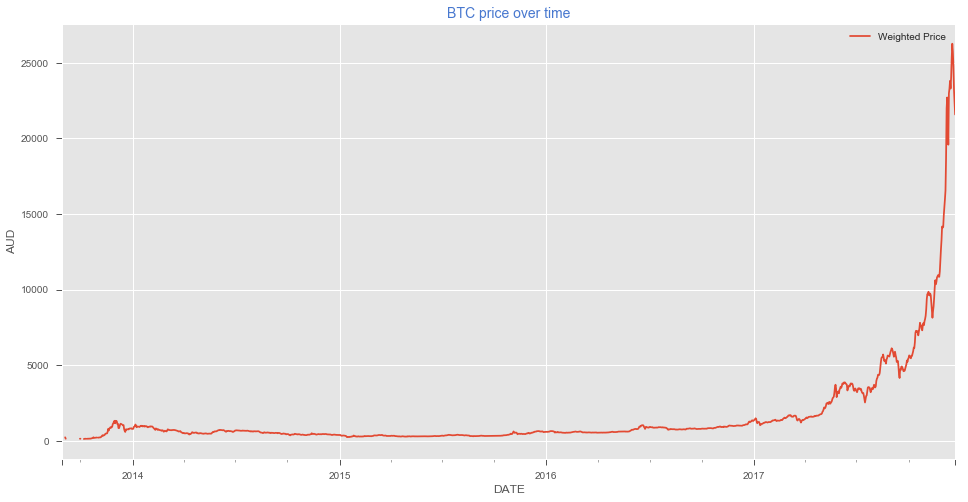

In [16]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
df_btc['Weighted Price'].plot()
plt.title('BTC price over time', color='B',size=14);plt.legend(loc='best');plt.ylabel('AUD');plt.xlabel('DATE')
plt.show()

Nice work! Damn, this beer is good and spotify is helping heaps.

## 04 Remove extraneous columns and keep values only from 2015.

I'm taking altcoin data only from 2015. So no point in simply having BTC data from 2013.

In [17]:
df_btc = df_btc[df_btc.index>='2015-01-01']

In [18]:
df_btc.shape

(1087, 7)

In [19]:
df_btc.drop(['Open','High','Low','Close','Volume (BTC)','Volume (Currency)'],axis=1,inplace=True)

In [20]:
df_btc.tail()

,Weighted Price
Date,
2017-12-18,25754.4907974000
2017-12-19,24767.2753103000
2017-12-20,23223.9468641000
2017-12-21,22317.1472059000
2017-12-22,21586.5094152000


## 05 Get altcoin data

For altcoins, I'll be using [the Poloneix API](https://poloniex.com/support/api/). For this we need to download data with respect to bitcoin data as a pair. I'm going to call this a poloneix pair. 

In [21]:
# these are the coins that Divsi has invested in. The ones I've marked with "--", 
# I'm unable to find a polo exchange equivalent. Needs further investigation
# lst_altcoins = ['ANS--','ARDR','BCC--','BCN','DASH','DGB','ETH','LTC','NXS--','OMG','PAY--','STEEM','STR','XRP','XVG--']
lst_altcoins = ['ARDR','BCN','DASH','DGB','ETH','LTC','OMG','STEEM','STR','XRP', 'XEM']
lst_altcoins

['ARDR',
 'BCN',
 'DASH',
 'DGB',
 'ETH',
 'LTC',
 'OMG',
 'STEEM',
 'STR',
 'XRP',
 'XEM']

In [22]:
# builds the json call request for "returnChartData" as per the polo documentation
# these are used in the json_url variable
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair=BTC_{}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
timePeriod = 86400 # pull daily data (86,400 seconds per day)

Similar to the bitcoin data, make the api call request only if you dont already have the data stored. this is because you hit the api limit on that day in the sub-station cafe.

In [23]:
bool_i_prefer_to_work_offline

False

In [24]:
if bool_i_prefer_to_work_offline==False:
    # initialises an empty dataframe to get the data
    df_altcoin = pd.DataFrame()

    # looping over each altcoin
    for altcoin_fetch in lst_altcoins:
        json_url = base_polo_url.format(altcoin_fetch, start_date.timestamp(), end_date.timestamp(), timePeriod)
        df_tmp = pd.read_json(json_url).drop(['close','high','low','open','quoteVolume','volume'], axis=1)
        
        df_tmp = df_tmp.set_index('date')
        df_tmp.rename(columns={'weightedAverage':altcoin_fetch+'_in_BTC'},inplace=True)
        df_altcoin = pd.concat([df_altcoin,df_tmp],axis=1) 
    
    # now push this to a csv
    df_altcoin.to_csv('POLO_ALTCOINS_IN_BTC'+'_'+datetime.today().strftime('%Y%m%d')+'.csv')
else:
    %time df_altcoin = pd.read_csv('POLO_ALTCOINS_IN_BTC_'+date_of_latest_available_data+'.csv', parse_dates=['date'])
    df_altcoin.set_index('date',inplace=True)

In [25]:
df_altcoin.shape

(1091, 11)

In [26]:
df_altcoin.head()

,ARDR_in_BTC,BCN_in_BTC,DASH_in_BTC,DGB_in_BTC,ETH_in_BTC,LTC_in_BTC,OMG_in_BTC,STEEM_in_BTC,STR_in_BTC,XRP_in_BTC,XEM_in_BTC
date,,,,,,,,,,,
2015-01-01,nan,0.0000000200,0.0062464500,nan,nan,0.0085585900,nan,nan,0.0000172800,0.0000757900,nan
2015-01-02,nan,0.0000000200,0.0062520100,nan,nan,0.0085039400,nan,nan,0.0000175300,0.0000776200,nan
2015-01-03,nan,0.0000000200,0.0060303900,nan,nan,0.0079256100,nan,nan,0.0000169700,0.0000739500,nan
2015-01-04,nan,0.0000000200,0.0061633100,nan,nan,0.0075151800,nan,nan,0.0000163400,0.0000686600,nan
2015-01-05,nan,0.0000000200,0.0060876800,nan,nan,0.0076602200,nan,nan,0.0000179600,0.0000739500,nan


In [27]:
# # lets back this shit up in case I want to analyse this without the interwebs!
# df_altcoin.to_csv('POLO_ALTCOINS_IN_BTC_20170923.csv')

In [28]:
df_combined= pd.merge(left=df_btc,right=df_altcoin,
                      how='left',
                     left_index=True,right_index=True)
df_combined.shape

(1087, 12)

In [29]:
for altcoin_fetch in lst_altcoins:
    df_combined[altcoin_fetch+'_in_AUD']=df_combined['Weighted Price']*df_combined[altcoin_fetch+'_in_BTC']
df_combined.shape

(1087, 23)

In [30]:
df_combined.tail(3)

,Weighted Price,ARDR_in_BTC,BCN_in_BTC,DASH_in_BTC,DGB_in_BTC,ETH_in_BTC,LTC_in_BTC,OMG_in_BTC,STEEM_in_BTC,STR_in_BTC,...,BCN_in_AUD,DASH_in_AUD,DGB_in_AUD,ETH_in_AUD,LTC_in_AUD,OMG_in_AUD,STEEM_in_AUD,STR_in_AUD,XRP_in_AUD,XEM_in_AUD
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-20,23223.9468641000,0.0000625000,0.0000002800,0.0810378100,0.0000027000,0.0469515700,0.0189658100,0.0010231600,0.0001816200,0.0000141400,...,0.0065027051,1882.0177934230,0.0627046565,1090.4007668661,440.4609636746,23.7618134735,4.2179332295,0.3283866087,0.9800505577,1.2422489178
2017-12-21,22317.1472059000,0.0000750900,0.0000003800,0.0879905700,0.0000031900,0.0496686700,0.0189894400,0.0010813400,0.0002276200,0.0000157900,...,0.0084805159,1963.6985034210,0.0711916996,1108.4630199113,423.7901278376,24.1324239596,5.0798290470,0.3523877544,1.3205056002,1.3236300008
2017-12-22,21586.5094152000,0.0000744100,0.0000003400,0.0807759100,0.0000028300,0.0484667100,0.0183877600,0.0009412200,0.0002082300,0.0000159200,...,0.0073394132,1743.6699417363,0.0610898216,1046.2270917388,396.9275543644,20.3176543918,4.4949588555,0.3436572299,1.5771103779,1.2122983688


Spot check: <br>
The data says ETHEREUM price was A\$308.3833640411 on 14/9/2017. Coinbase price is \$335 AUD as at 10:00 AM. <br>
The data says DASH price was A\$244.067 on 6/8/2017. Worldcoinindex price for that day is \$244.32<br>
So the data is directional and definitely usable.

In [31]:
df_combined.index.max(), df_combined.index.min()

(Timestamp('2017-12-22 00:00:00'), Timestamp('2015-01-01 00:00:00'))

In [32]:
# same type of 0 replacement as you did for BTC
cols_to_replace = ['ARDR_in_AUD',
       'BCN_in_AUD', 'DASH_in_AUD', 'DGB_in_AUD', 'ETH_in_AUD',
       'LTC_in_AUD', 'OMG_in_AUD', 'STEEM_in_AUD', 'STR_in_AUD',
       'XRP_in_AUD']
for cols in cols_to_replace:
    df_combined[cols].replace(0,np.nan, inplace=True)

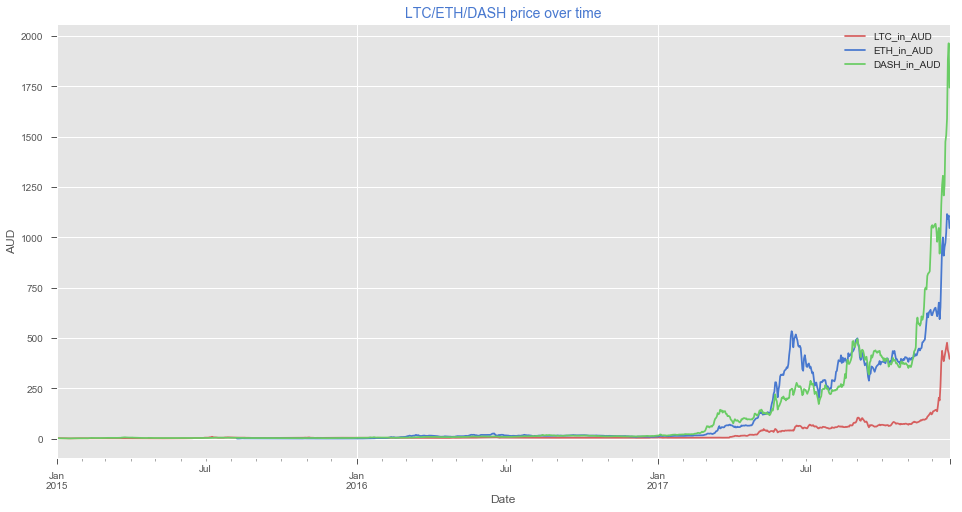

In [33]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
df_combined['LTC_in_AUD'].plot(color='r')
df_combined['ETH_in_AUD'].plot(color='b')
df_combined['DASH_in_AUD'].plot(color='g')
plt.title('LTC/ETH/DASH price over time', color='B',size=14);plt.legend(loc='best');plt.ylabel('AUD');plt.xlabel('Date')
plt.show()

## Normalise coins because you'd be comparing apples to oranges

In [34]:
df_combined.rename(columns={'Weighted Price':'BTC_in_AUD'},inplace=True)

In [35]:
# fix combined such that BTC and altcoins are all on the same time scale
df_combined = df_combined[df_combined.index>='2015-01-01']

In [36]:
cols_to_normalise = [col for col in df_combined.columns if 'in_AUD' in col]
for cols in cols_to_normalise:
    df_combined['norm_'+cols]=df_combined[cols].apply(lambda x:(x-df_combined[cols].min())/(df_combined[cols].max()-df_combined[cols].min()))

In [37]:
['norm_'+col for col in cols_to_normalise]

['norm_BTC_in_AUD',
 'norm_ARDR_in_AUD',
 'norm_BCN_in_AUD',
 'norm_DASH_in_AUD',
 'norm_DGB_in_AUD',
 'norm_ETH_in_AUD',
 'norm_LTC_in_AUD',
 'norm_OMG_in_AUD',
 'norm_STEEM_in_AUD',
 'norm_STR_in_AUD',
 'norm_XRP_in_AUD',
 'norm_XEM_in_AUD']

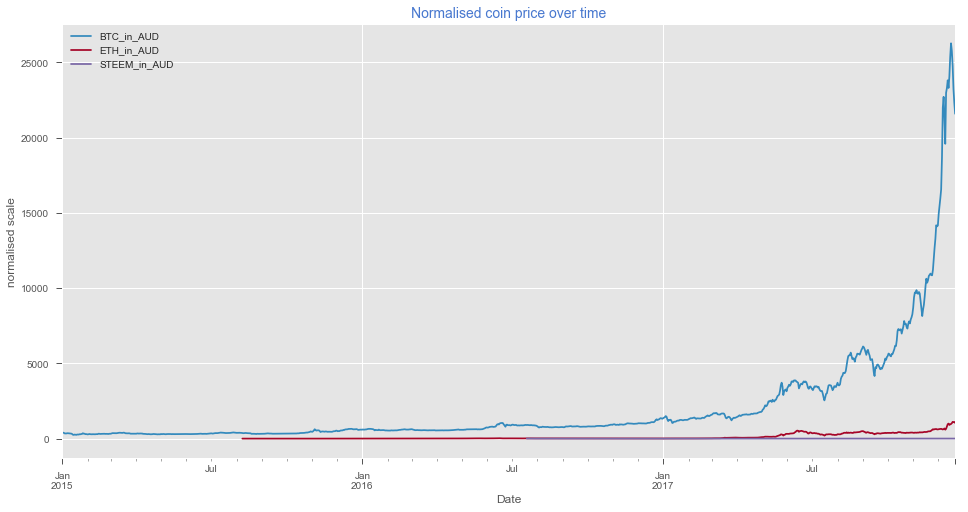

In [38]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8));ax = fig.add_subplot(111)
iter_colour = itertools.cycle(COLOR_PALETTE)
# for cols in ['norm_'+col for col in cols_to_normalise]:
# for cols in ['norm_BTC_in_AUD','norm_ETH_in_AUD','norm_LTC_in_AUD','norm_STEEM_in_AUD']:
for cols in ['BTC_in_AUD','ETH_in_AUD','STEEM_in_AUD']:
    df_combined[cols].plot(color=next(iter_colour))
plt.title('Normalised coin price over time', color='B',size=14);
plt.legend(loc='best');plt.ylabel('normalised scale');plt.xlabel('Date');plt.show()

In [39]:
if bool_i_prefer_to_work_offline==False:
    df_combined.to_pickle('btc_altcoin_cleansed_'+date_of_latest_available_data+'.pickle')